In [ ]:
#copy cudnn files to corresponding folder
!sudo cp /content/drive/MyDrive/cuda/include/* /usr/local/cuda-11.0/include/
!sudo cp /content/drive/MyDrive/cuda/lib64/* /usr/local/cuda-11.0/lib64/
!sudo chmod a+r /usr/local/cuda-11.0/include/cudnn.h
!sudo chmod a+r /usr/local/cuda-11.0/lib64/libcudnn*

In [ ]:
#two orders need to be executed inside the command, otherwise it will not work
!export PATH=/usr/local/cuda-11.0/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin
!export LD_LIBRARY_PATH=/usr/local/cuda-11.0/lib64/
!export LIBRARY_PATH=/usr/local/cuda-11.0/lib64/stubs

In [ ]:
import random, string, urllib.request, json, getpass

#Generate root password
password = ''.join(random.choice(string.ascii_letters + string.digits) for i in range(20))

#Download ngrok
! wget -q -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip -qq -n ngrok-stable-linux-amd64.zip

#Setup sshd
! apt-get install -qq -o=Dpkg::Use-Pty=0 openssh-server pwgen > /dev/null

#Set root password
! echo root:$password | chpasswd
! mkdir -p /var/run/sshd
! echo "PermitRootLogin yes" >> /etc/ssh/sshd_config
! echo "PasswordAuthentication yes" >> /etc/ssh/sshd_config
! echo "LD_LIBRARY_PATH=/usr/lib64-nvidia" >> /root/.bashrc
! echo "export LD_LIBRARY_PATH" >> /root/.bashrc

#Run sshd
get_ipython().system_raw('/usr/sbin/sshd -D &')

#Ask token
print("Copy authtoken from https://dashboard.ngrok.com/auth")
authtoken = getpass.getpass()

#Create tunnel
get_ipython().system_raw('./ngrok authtoken $authtoken && ./ngrok tcp 22 &')

#Get public address and print connect command
with urllib.request.urlopen('http://localhost:4040/api/tunnels') as response:
  data = json.loads(response.read().decode())
  (host, port) = data['tunnels'][0]['public_url'][6:].split(':')
  print(f'SSH command: ssh -p{port} root@{host}')

#Print root password
print(f'Root password: {password}')

Copy authtoken from https://dashboard.ngrok.com/auth
··········
SSH command: ssh -p17097 root@4.tcp.ngrok.io
Root password: 1b4vRns6lXpnrYFFlqyX


In [ ]:
#HRF training
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import random
import numpy as np
import heapq
import pickle 

from google.colab import drive
drive.mount('/content/drive') #authorize google drive
sys.path.append('/content/drive/MyDrive/MyProject/') #the storage path of my own modules
from keras.callbacks import EarlyStopping
from util import *
from unet import *
from pre_processing import *
from sklearn.model_selection import train_test_split
from keras import backend as K
#from keras.utils import plot_model

def margin_sampling(probability_map1, probability_map2):
  maximum_probs = np.maximum(probability_map1, probability_map2)
  minimum_probs = np.minimum(probability_map1, probability_map2)
  deduction = maximum_probs - minimum_probs
  #print(deduction.shape)
  #calculate the Euclidean Distance #np.round(np.sqrt(np.sum(np.square(deduction))),6)
  return np.round(np.mean(deduction),6), deduction

def least_confidence(probability_map1, probability_map2):
  #next step is equal to 1 - np.minimumprobability_map1, probability_map2)
  least_confidence = 1 - np.maximum(probability_map1, probability_map2)
  #calculate the Euclidean Distance #np.round(np.sqrt(np.sum(np.square(least_confidence))),6)
  return np.round(np.mean(least_confidence),6), least_confidence

def entropy_sampling(probability_map1, probability_map2):
  #base = 10
  item1 = np.multiply(probability_map1,np.log10(probability_map1))
  item2 = np.multiply(probability_map2,np.log10(probability_map2))
  sum_of_item = -(item1+item2)
  #calculate the Euclidean Distance
  return np.round(np.mean(sum_of_item),6), sum_of_item

def EGL(probability_map1, probability_map2, grads_norm):
  item1 = probability_map1 * grads_norm
  item2 = probability_map2 * grads_norm
  item = item1 + item2
  return np.round(np.mean(item),6)

def tversky(y_true, y_pred, smooth=1):
  y_true_pos = K.flatten(y_true)
  y_pred_pos = K.flatten(y_pred)
  true_pos = K.sum(y_true_pos * y_pred_pos)
  false_neg = K.sum(y_true_pos * (1-y_pred_pos))
  false_pos = K.sum((1-y_true_pos)*y_pred_pos)
  alpha = 0.5
  return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
  return 1 - tversky(y_true, y_pred, smooth=1)
  
if __name__ == '__main__':

  # parameters and paths
  # DRIVE resize:(576, 576)
  # HRF resize:(2920, 2920)
  # IOSTAR resize:(1024, 1024)
  resize_height, resize_width = (960, 1440)
  # DRIVE patch size:48
  # HRF patch size:292
  # IOSTAR resize:64
  dx = 96
  # dataset option: DRIVE, HRF and IOSTAR
  dataset = "HRF"

  #start dealing with testing dataset
  test_img_path = '/content/drive/MyDrive/MyProject/'+dataset+'/test/images/'
  test_label_path = '/content/drive/MyDrive/MyProject/'+dataset+'/test/1st_manual/'

  # read the test data and resize them into patches
  # read the data and resize them
  test_imglst,test_images = read_image_and_name(test_img_path)
  test_labellst,test_labels = read_label_and_name(test_label_path)

  test_imgs_resize = resize(test_images,resize_width,resize_height)
  test_labels_resize = resize(test_labels,resize_width,resize_height)

  # convert the list imgs and manuals to the numpy array
  X_test_set = np.array(test_imgs_resize)
  Y_test_set = np.array(test_labels_resize)
  print(X_test_set.shape)
  print(Y_test_set.shape)

  # do the standardization to the image, each pixel value will be
  # restricted within 0 to 1
  X_test_set = X_test_set.astype('float32')/255
  Y_test_set = Y_test_set.astype('float32')/255

  # do the pre-processing operations to the training images
  X_test_set = my_PreProc(X_test_set)

  # making testing images become some image patches used for evaluation
  X_eval = []
  Y_eval = []
  for k in range(X_test_set.shape[0]):     
    X_test = X_test_set[k,...]
    Y_test = Y_test_set[k,...]
    # crop images to be predicted to (144,48,48), the row order first
    list1 = []
    list2 = []
    for i in range(resize_height//dx):
      for j in range(resize_width//dx):
        list1.append(X_test[i*dx:(i+1)*dx, j*dx:(j+1)*dx])
        list2.append(Y_test[i*dx:(i+1)*dx, j*dx:(j+1)*dx])
    X_test = np.array(list1)[:,np.newaxis,...] #increase one dimension, it will become (144,1,48,48)
    Y_test = np.array(list2)[:,np.newaxis,...] #increase one dimension, it will become (144,1,48,48)

    X_eval.append(X_test)
    Y_eval.append(Y_test)
  
  X_eval = np.concatenate(X_eval, axis=0)
  Y_eval = np.concatenate(Y_eval, axis=0)

  Y_eval = Y_eval.reshape(Y_eval.shape[0],-1)
  # increase one dimension, make it become (2880,2304,1)
  Y_eval = Y_eval[..., np.newaxis]
  # get the groundtruth for another class
  temp = 1 - Y_eval
  # make it become (2880,2304,2)
  Y_eval = np.concatenate([Y_eval, temp], axis=2)

  print(X_eval.shape)
  print(Y_eval.shape)
  
  #start dealing with training images
  img_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/images/'
  label_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/1st_manual/'

  # read the data and resize them
  imglst,images = read_image_and_name(img_path)
  labellst,labels = read_label_and_name(label_path)
  
  # pre selected annotated samples by active learning(including 22 training images)
  # range [2, 6, 10, 14, 18, 20, 22]
  selected_image_nums = [2, 6, 10, 14, 18, 20]  #it could be gained by percent as well, like int(0.5*len(data))

  #set the name of method will be used, selective options
  #"random_sampling", "margin_sampling", "least_confidence", "entropy_sampling", "density_weighted"
  methods = ["random_sampling", "margin_sampling", "least_confidence", "entropy_sampling", "density_weighted"]

  # randomly selected N(stored inside the variable imglst) samples from the training dataset
  # due to the uncertainty of accuracy from the initialized classifier, take labeled data in advance
  selected_data_set = []
  selected_label_set = []
  sample_index_set = []
  image_index = [i for i in range(len(images))]
  for selected_image_num in selected_image_nums:
    sample_index = random.sample(image_index, selected_image_num)
    sample_data = [images[i] for i in sample_index]
    sample_label = [labels[i] for i in sample_index]
    selected_data_set.append(sample_data)
    selected_label_set.append(sample_label)
    sample_index_set.append(sample_index)

  for method in methods:
    for selected_index, selected_item in enumerate(selected_image_nums):
      sample_data = selected_data_set[selected_index]
      sample_label = selected_label_set[selected_index]
      sample_index = sample_index_set[selected_index]
      
      #check if the order of images and labels is not corresponding
      plt.figure()
      plt.imshow(sample_data[1])
      plt.show()

      plt.figure()
      plt.imshow(sample_label[1],'gray')
      plt.show()

      imgs_resize = resize(sample_data,resize_width,resize_height)
      labels_resize = resize(sample_label,resize_width,resize_height)

      # convert the list imgs and manuals to the numpy array
      X_train = np.array(imgs_resize)
      Y_train = np.array(labels_resize)
      print(X_train.shape)
      print(Y_train.shape)


      # do the standardization to the image, each pixel value will be
      # restricted within 0 to 1
      X_train = X_train.astype('float32')/255
      Y_train = Y_train.astype('float32')/255

      # do the pre-processing operations to the training images
      X_train = my_PreProc(X_train)

      print(X_train.shape)
      plt.figure()
      plt.imshow(X_train[1,:,:,0],'gray')
      plt.show()

      plt.figure()
      plt.imshow(Y_train[1,:,:],'gray')
      plt.show()

      print('X_train shape: ' + str(X_train.shape))  # X_train(2880,48,48)
      print('Y_train shape: ' + str(Y_train.shape))  # Y_train(2880,48,48)

      # crop training images
      patches_num = 500;       #required patches num 1000

      #initial two variables used for recording patch numbers， their corresponding accuracy， and their correpsonding loss
      patch_numset = []
      patch_accuracyset = []
      patch_losset = []

      X_train, Y_train = extract_random(X_train, Y_train, dx, dx, patches_num*selected_item)
      print('X_train shape: '+str(X_train.shape)) #X_train(2880,48,48)
      print('Y_train shape: '+str(Y_train.shape)) #Y_train(2880,48,48)
      
      #Save a sample of what you're feeding to the neural network
      N_sample = min(X_train.shape[0],40)
      temp_Ytrain = Y_train[...,np.newaxis]
      #visualize(,'/content/drive/MyDrive/MyProject/'+dataset+'/samples/sample_input_imgs')
      visualize(group_images(X_train[0:N_sample,:,:,:],5),'/content/drive/MyDrive/MyProject/'+dataset+'/samples/sample_input_imgs')
      visualize(group_images(temp_Ytrain[0:N_sample,:,:,:],5),'/content/drive/MyDrive/MyProject/'+dataset+'/samples/sample_output_imgs')

      plt.figure()
      plt.imshow(X_train[12,:,:,0],'gray')
      plt.show()

      plt.figure()
      plt.imshow(Y_train[12,:,:],'gray')
      plt.show()
      
      # Increase one dimension to X_train, the dimension will become (2880,1,48,48)
      X_train = X_train[:,np.newaxis, ...]
      print('X_train shape: '+str(X_train.shape))
      # change the shape of Y_train, make it become (2880,2304), keep the first dimension
      # unchanged, merge other dimensions
      Y_train = Y_train.reshape(Y_train.shape[0],-1)
      print('Y_train shape: '+str(Y_train.shape))
      # increase one dimension, make it become (2880,2304,1)
      Y_train =Y_train[..., np.newaxis]
      print('Y_train shape: '+str(Y_train.shape))
      temp = 1 - Y_train
      # make it become (2880,2304,2)
      Y_train = np.concatenate([Y_train, temp], axis=2)
      print('Y_train shape: '+str(Y_train.shape))
      print('X_train shape: '+str(X_train.shape))
      
      
      # model is gained
      n_label = 2   #number of classes
      model = None
      model = get_unet(X_train.shape[1],X_train.shape[2],X_train.shape[3],n_label)

      #set early stopping to prevent overfit
      early_stopping = EarlyStopping(monitor='loss',patience=3,verbose=2)
      
      model.summary()  # output the calculation process of parameter Param
      checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/MyProject/'+dataset+'/training_records/'+dataset+'_best_weights('+method+'_'+str(selected_item)+
                                      ').h5',verbose=1,monitor='val_accuracy',mode='auto',save_best_only=True)
      
      model.compile(optimizer=Adam(lr=0.0005),loss='categorical_crossentropy',metrics=['accuracy'])

      #plot_model(model, to_file='/content/drive/MyDrive/MyProject/'+dataset+'/unet_model.png')

      #split 80% for training and 20% for validation
      seed = 7
      np.random.seed(seed)
      X_trainset, X_testset, Y_trainset, Y_testset = train_test_split(X_train, Y_train, test_size=0.2, random_state=seed)

      history1 = model.fit(X_trainset,Y_trainset,batch_size=64,epochs=10,verbose=2,shuffle=True,validation_data=(X_testset, Y_testset),callbacks=[checkpointer,early_stopping])

      if selected_item == 22:
        model.load_weights(filepath='/content/drive/MyDrive/MyProject/'+dataset+'/training_records/'+dataset+'_best_weights('+method+'_'+str(selected_item)+').h5')
        supervised_loss, supervised_accuracy = model.evaluate(X_eval, Y_eval)
        sup = {dataset+'_supervised_accuracy':supervised_accuracy}
        with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/'+method+'_supervised_accuracy.txt','wb+') as file_pi:
          pickle.dump(sup, file_pi)
        exit()

      # use the uncertainty and fine-tuning to train this model
      training_samples_num = selected_item * patches_num
      # patches number extracted from unlabeled images
      unlabeled_patches_num = 100
      
      #reload weights for evaluation
      model.load_weights(filepath='/content/drive/MyDrive/MyProject/'+dataset+'/training_records/'+dataset+'_best_weights('+method+'_'+str(selected_item)+').h5')
      patch_numset.append(X_trainset.shape[0])
      valid_loss, valid_accuracy = model.evaluate(X_eval, Y_eval)
      patch_accuracyset.append(valid_accuracy)
      patch_losset.append(valid_loss)

      active_indice = [i for i in image_index if i not in sample_index]
      print("active_indice:"+str(active_indice))

      final_new_train_samples = X_trainset
      final_new_train_labels = Y_trainset

      epochs = 0

      #start the for-loop from here
      #while len(active_indice) != 0:
      #a = 1
      #while a == 1:

      #a = 1
      #a = 1
      while len(active_indice) != 0:
          
        active_image_data = [images[i] for i in active_indice]
        active_image_label = [labels[i] for i in active_indice]

        active_imgs_resize = resize(active_image_data,resize_width,resize_height)
        active_labels_resize = resize(active_image_label,resize_width,resize_height)

        #extract patches from unlabeled images again, take their labels meanwhile
        #convert the list imgs and manuals to the numpy array
        active_X_train = np.array(active_imgs_resize)
        active_Y_train = np.array(active_labels_resize)

        # do the standardization to the image, each pixel value will be
        # restricted within 0 to 1
        active_X_train = active_X_train.astype('float32')/255
        active_Y_train = active_Y_train.astype('float32')/255

        # do the pre-processing operations to the training images
        active_X_train = my_PreProc(active_X_train)
        print('active_X_train shape: '+str(active_X_train.shape)) 
        print('active_Y_train shape: '+str(active_Y_train.shape))
        
        sample_confidence = []
        if method is not "random_sampling":
          #active_samples_num = len(active_indice) * unlabeled_patches_num
          for k in range(active_X_train.shape[0]):   
            list1 = []
            list2 = []
            for i in range(resize_height//dx):
              for j in range(resize_width//dx):
                list1.append(active_X_train[k,...][i*dx:(i+1)*dx, j*dx:(j+1)*dx])
                list2.append(active_Y_train[k,...][i*dx:(i+1)*dx, j*dx:(j+1)*dx])
            active_prediction_samples = np.array(list1)[:,np.newaxis,...] #increase one dimension, it will become (144,1,48,48)
            active_groundtruth_samples = np.array(list2)[:,np.newaxis,...]
            #print('active_X_train shape: '+str(active_prediction_samples.shape)) 
            #print('active_Y_train shape: '+str(active_Y_train.shape))

            #print(new_X_train.shape)
            Y_pred_train = model.predict(active_prediction_samples)
            print('predict shape: '+str(Y_pred_train.shape))

            Y_pred1 = Y_pred_train[...,0]
            Y_pred2 = Y_pred_train[...,1]

            probability_map1 = np.zeros((resize_height, resize_width))
            probability_map2 = np.zeros((resize_height, resize_width))

            t = 0
            for i in range(resize_height//dx):
              for j in range(resize_width//dx):
                temp1 = Y_pred1[t].reshape(dx, dx)
                temp2 = Y_pred2[t].reshape(dx, dx)
                probability_map1[i*dx:(i+1)*dx, j*dx:(j+1)*dx] = temp1
                probability_map2[i*dx:(i+1)*dx, j*dx:(j+1)*dx] = temp2
                t = t + 1
            
            probability_map1 = cv2.resize(probability_map1,(resize_height,resize_width))
            probability_map2 = cv2.resize(probability_map2,(resize_height,resize_width))

            """
            #the raw image
            plt.figure(figsize=(12,12))
            plt.imshow(active_X_train[k,...,0],'gray')
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
            plt.show()
            #probability map
            plt.figure(figsize=(12,12))
            plt.imshow(probability_map1,'gray')
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
            plt.show()
            """
            
            #output one to see the probability
            #print('probability:'+str(Y_pred_train[1,:,0]))
            #print('probability:'+str(Y_pred_train[1,:,1]))

            #calculate every unannotated image's uncertainty
            #S = np.round(compute_matrix(Y_pred_train, 0, 1, 1),2)
            if method == "margin_sampling":
              S, active_map = margin_sampling(probability_map1, probability_map2)
              """
              active_map = active_map.astype(np.uint8)
              weights = cv2.applyColorMap(active_map, 2)
              attention_map = active_X_train[k,...] * 0.4 + weights * 0.6
              attention_map = attention_map.astype(np.uint8)
              plt.figure(figsize=(12,12))
              plt.imshow(attention_map)
              plt.xticks([])
              plt.yticks([])
              plt.axis('off')
              plt.show()
              """
            elif method == "least_confidence":
              S, active_map = least_confidence(probability_map1, probability_map2)
            elif method == "entropy_sampling":
              S, active_map = entropy_sampling(probability_map1, probability_map2)
            elif method == "excepted_gradient_length":
              real_y = active_groundtruth_samples
              real_y = real_y.reshape(real_y.shape[0],-1)
              real_y = real_y[...,np.newaxis]
              temp = 1 - real_y
              real_y = np.concatenate([real_y, temp], axis=2)
              
              with tf.GradientTape() as tape:
                cce = tf.keras.losses.CategoricalCrossentropy()
                pred_y = model(active_prediction_samples)
                ce_loss = cce(real_y, pred_y)
              
              grads = tape.gradient(ce_loss,model.trainable_variables)
              grads_norm = 0
              #print(len(grads))
              for i in range(len(grads)):
                grads_norm = grads_norm + np.linalg.norm(x=grads[i].numpy().flatten(),ord=2)
              #print(grads_norm)
              S = EGL(probability_map1, probability_map2, grads_norm)

            elif method == "density_weighted":
              entropy_score, active_map = entropy_sampling(probability_map1, probability_map2)
              similarity_sum = 0
              current_index = k
              for m in range(active_X_train.shape[0]):
                if m != k:
                  #calculate the similarity
                  euc_deduction = active_X_train[k,...,0] - active_X_train[m,...,0]
                  euclidean_dis = np.sqrt(np.sum(np.square(euc_deduction)))
                  #convert the euclidean distance to similarity
                  similarity = 1/(1+euclidean_dis)
                  similarity_sum = similarity_sum + similarity
              #active_map = active_map * np.power(np.mean(similarity_sum),1)
              
              S = entropy_score * np.power(np.mean(similarity_sum),1)

            sample_confidence.append(S)
            
        #print(active_scores)
        print(sample_confidence)

        #sample_confidence:convert list to array
        sample_confidence = np.array(sample_confidence)
        
        #smallest_index = [index for index,value in enumerate(sample_confidence) if value==min(sample_confidence)]
        #find the elements with lowest/highest active scores
        smallest_index = []
        selected_num = 1 #2 3
        if method == "random_sampling":
          current_active_indice = [i for i in range(len(active_indice))];
          if len(current_active_indice)<selected_num:
            smallest_index = random.sample(current_active_indice, len(current_active_indice))
          else:
            smallest_index = random.sample(current_active_indice, selected_num)
        elif method == "margin_sampling":
          sorts = np.argsort(sample_confidence)
          if len(sorts) < selected_num:
            smallest_index = sorts
          else:
            smallest_index = sorts[0:selected_num]
        elif method == "least_confidence":
          sorts = np.argsort(-sample_confidence)
          if len(sorts) < selected_num:
            smallest_index = sorts
          else:
            smallest_index = sorts[0:selected_num]
        elif method == "entropy_sampling":
          sorts = np.argsort(-sample_confidence)
          if len(sorts) < selected_num:
            smallest_index = sorts
          else:
            smallest_index = sorts[0:selected_num]
        elif method == "excepted_gradient_length":
          sorts = np.argsort(-sample_confidence)
          if len(sorts) < selected_num:
            smallest_index = sorts
          else:
            smallest_index = sorts[0:selected_num]
        elif method == "density_weighted":
          sorts = np.argsort(-sample_confidence)
          if len(sorts) < selected_num:
            smallest_index = sorts
          else:
            smallest_index = sorts[0:selected_num]
        
        smallest_elements = [active_X_train[i] for i in smallest_index]
        smallest_labels = [active_Y_train[i] for i in smallest_index]

        reshaped_elements = []
        reshaped_labels = []
        for tuning_item, tuning_label in zip(smallest_elements, smallest_labels):
          item = [tuning_item]
          label = [tuning_label]
          tuning_item = resize(item,resize_width,resize_height)
          tuning_label = resize(label,resize_width,resize_height)

          tuning_item = np.array(tuning_item)
          tuning_label = np.array(tuning_label)

          #smallest_elements, smallest_labels = extract_random(smallest_elements, smallest_labels, dx, dx, unlabeled_patches_num*len(smallest_index))
          
          temp_elements = []
          temp_labels = []
          for a, b in zip(tuning_item, tuning_label):
            for i in range(resize_height//dx):
              for j in range(resize_width//dx):
                temp_elements.append(a[i*dx:(i+1)*dx, j*dx:(j+1)*dx])
                temp_labels.append(b[i*dx:(i+1)*dx, j*dx:(j+1)*dx])

          temp_elements = np.array(temp_elements)[:,np.newaxis,...,np.newaxis]
          temp_labels = np.array(temp_labels)[:,...,np.newaxis]

          reshaped_elements.append(temp_elements)
          reshaped_labels.append(temp_labels)

        smallest_elements = np.concatenate(reshaped_elements, axis=0)
        smallest_labels = np.concatenate(reshaped_labels, axis=0)
        print(smallest_elements.shape)
        print(smallest_labels.shape)

        #smallest_elements = smallest_elements[..., np.newaxis]

        # change the shape of Y_train, make it become (2880,2304), keep the first dimension
        # unchanged, merge other dimensions
        smallest_labels = smallest_labels.reshape(smallest_labels.shape[0],-1)
        print('smallest_labels shape: '+str(smallest_labels.shape))
        # increase one dimension, make it become (2880,2304,1)
        smallest_labels = smallest_labels[..., np.newaxis]
        print('Y_train shape: '+str(Y_train.shape))
        temp = 1 - smallest_labels
        # make it become (2880,2304,2)
        smallest_labels = np.concatenate([smallest_labels, temp], axis=2)

        print(smallest_elements.shape)
        print(smallest_labels.shape)          
        
        new_train_samples = []
        for i in range(final_new_train_samples.shape[0]):
          ori_element = final_new_train_samples[i,...]
          new_train_samples.append(ori_element[np.newaxis,:])
        for j in range(smallest_elements.shape[0]):
          new_element = smallest_elements[j,...]
          new_train_samples.append(new_element[np.newaxis,:])
        final_new_train_samples = np.concatenate(new_train_samples,axis=0)
        
        new_train_labels = []
        for i in range(final_new_train_labels.shape[0]):
          ori_label = final_new_train_labels[i,...]
          new_train_labels.append(ori_label[np.newaxis,:])
        for j in range(smallest_labels.shape[0]):
          new_label = smallest_labels[j,...]
          new_train_labels.append(new_label[np.newaxis,:])
        final_new_train_labels = np.concatenate(new_train_labels,axis=0)

        print('final_new_train_samples shape: '+str(final_new_train_samples.shape))
        print('final_new_train_labels shape: '+str(final_new_train_labels.shape))
      
        # use these 100 the most uncertain samples 
        # to do the fine-tuning to this network
        print("Use the pre trained model for fine tuning")
        print(model.layers)

        for layer in model.layers[:10]:
          layer.trainable = False
          #print(layer)
          #print("these layers won't be trained")
        for layer in model.layers[21:30]:
          layer.trainable = False
          #print(layer)
          #print("these layers won't be trained")
        
        print(len(model.layers))

        #set early stopping to prevent overfit
        #early_stopping = EarlyStopping(monitor='val_loss',patience=3,verbose=2)

        #model.summary()  # output the calculation process of parameter Param
        checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/MyProject/'+dataset+'/training_records/'+dataset+'_best_weights('+method+'_'+str(selected_item)+
                                      ').h5',verbose=1,monitor='accuracy',mode='auto',save_best_only=True)
        model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
        history2 = model.fit(final_new_train_samples,final_new_train_labels,batch_size=64,epochs=10,verbose=2,shuffle=True,callbacks=[checkpointer,early_stopping]) #,early_stopping

        model.load_weights(filepath='/content/drive/MyDrive/MyProject/'+dataset+'/training_records/'+dataset+'_best_weights('+method+'_'+str(selected_item)+').h5')
        valid_loss, valid_accuracy = model.evaluate(X_eval, Y_eval)
        patch_numset.append(final_new_train_labels.shape[0])
        patch_accuracyset.append(valid_accuracy)
        patch_losset.append(valid_loss)

        #update corresponding parameters
        ruleout_list = [active_indice[i] for i in smallest_index]
        active_indice = [x for x in active_indice if x not in ruleout_list]
        print('active indice:'+str(active_indice))
        active_samples_num = len(active_indice)*patches_num

        # draw corresponding loss figures
        history1.history['accuracy'].extend(history2.history['accuracy'])
        history1.history['loss'].extend(history2.history['loss'])
        
      #print(history1.history['accuracy'])
      #print(history1.history['loss'])

      #mode wb+ readable and writable, and files will be automatically created if they don't exist
      #binary mode
      patch_val_acc = {'patch_val_acc':patch_accuracyset}
      patch_num_count = {'patch_num_count':patch_numset}
      patch_val_loss = {'patch_losset':patch_losset}
      print(patch_num_count)
      print(patch_val_acc)

      with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/'+method+'_'+str(selected_item)+'.txt','wb+') as file_pi:
        pickle.dump(history1.history, file_pi)
      with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/'+method+'_'+str(selected_item)+'_patch_accuracy.txt','wb+') as file_pi:
        pickle.dump(patch_val_acc, file_pi)
      with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/'+method+'_'+str(selected_item)+'_patch_num.txt','wb+') as file_pi:
        pickle.dump(patch_num_count, file_pi)
      with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/'+method+'_'+str(selected_item)+'_patch_loss.txt','wb+') as file_pi:
        pickle.dump(patch_val_loss, file_pi)

      K.clear_session()
      tf.compat.v1.reset_default_graph()

Output hidden; open in https://colab.research.google.com to view.

# **The trend of training accuracy**

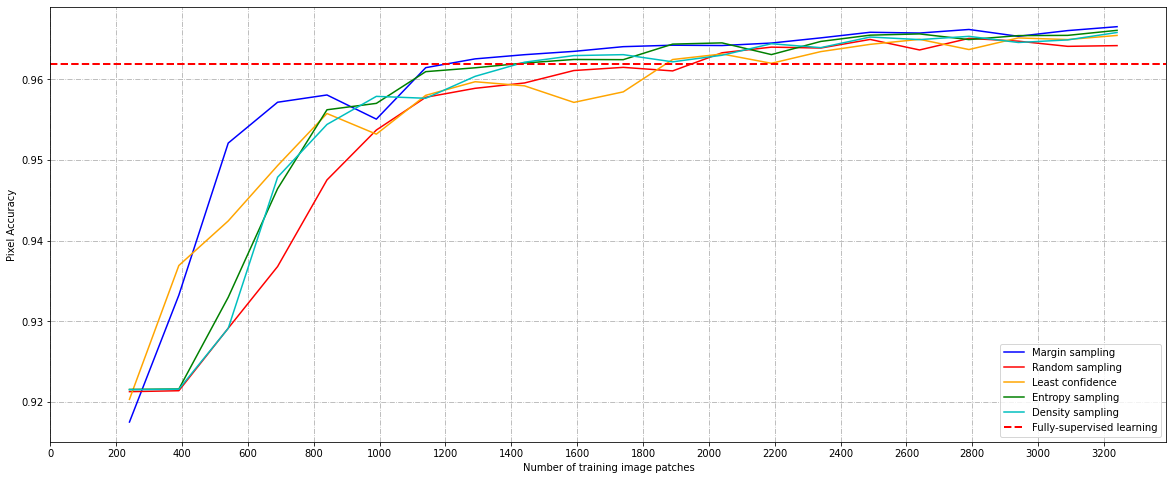

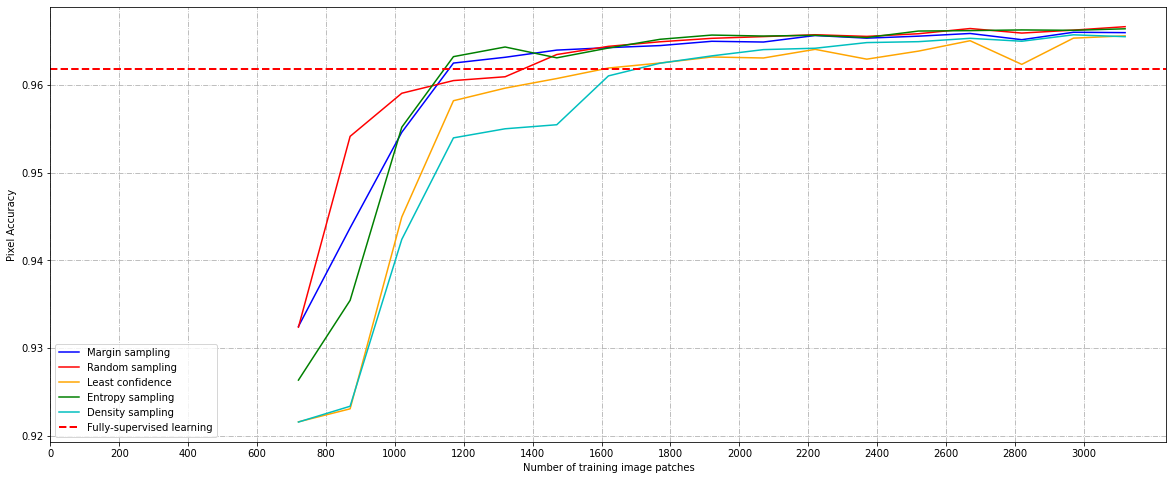

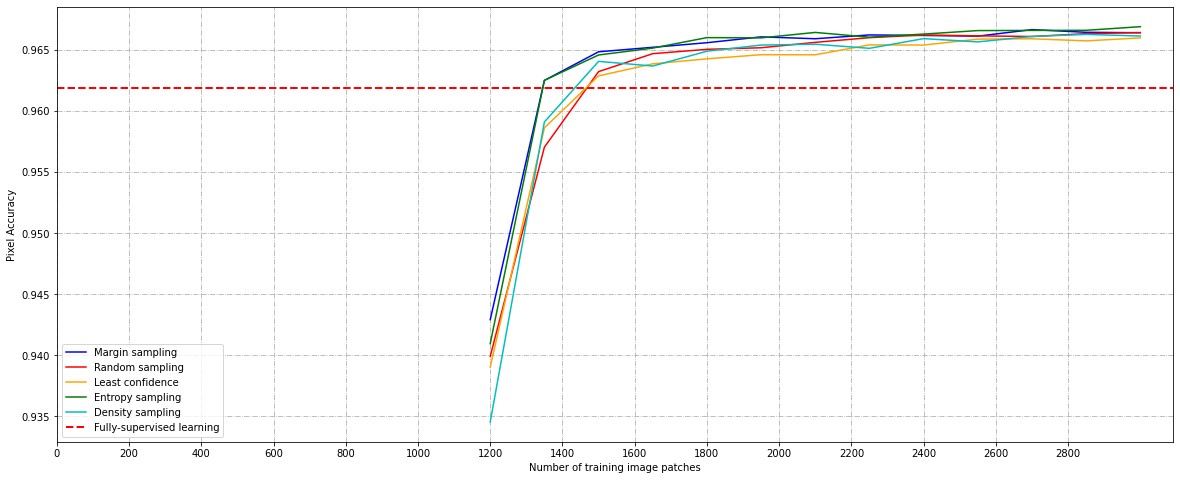

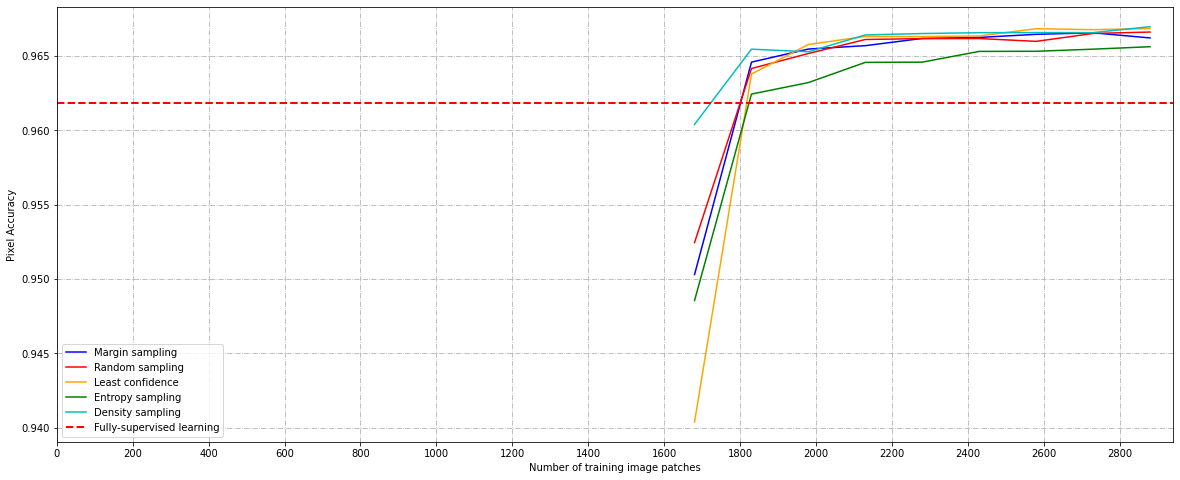

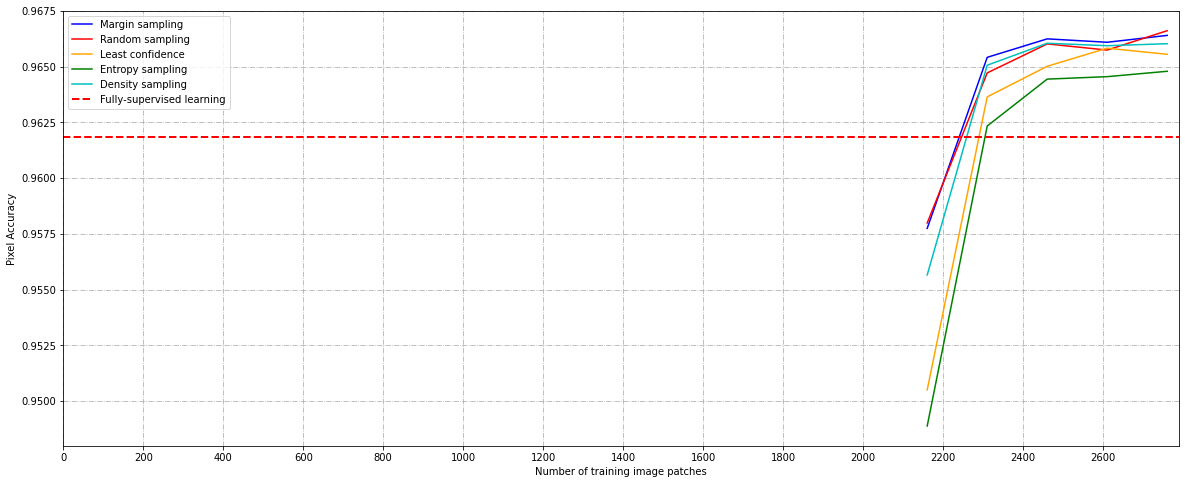

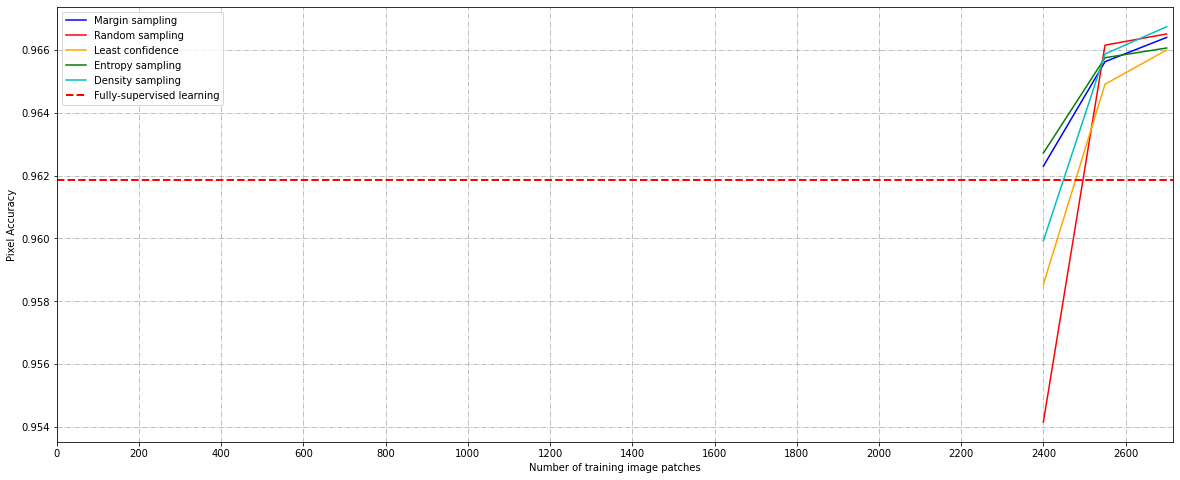

In [ ]:
#make pixel accuracy comparsion between different methods
import matplotlib.pyplot as plt
import pickle
import numpy as np

annotated_num = [2, 6, 10, 14, 18, 20] #2, 6, 10, 14, 18, 20, 22

max_annotated_num = 22

dataset = 'HRF'

for i in annotated_num: 
  #Pixel Accuracy
  with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/margin_sampling_'+str(i)+'_patch_accuracy.txt','rb+') as file_pi:
    margin_training = pickle.load(file_pi)
  with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/random_sampling_'+str(i)+'_patch_accuracy.txt','rb+') as file_pi:
    random_training = pickle.load(file_pi)
  with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/least_confidence_'+str(i)+'_patch_accuracy.txt','rb+') as file_pi:
    least_training = pickle.load(file_pi)
  with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/entropy_sampling_'+str(i)+'_patch_accuracy.txt','rb+') as file_pi:
    entropy_training = pickle.load(file_pi)
  with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/density_weighted_'+str(i)+'_patch_accuracy.txt','rb+') as file_pi:
    density_training = pickle.load(file_pi)

  margin_records = margin_training['patch_val_acc']
  random_records = random_training['patch_val_acc']
  least_records = least_training['patch_val_acc']
  entropy_records = entropy_training['patch_val_acc']
  density_records = density_training['patch_val_acc']

  with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/margin_sampling_'+str(i)+'_patch_num.txt','rb+') as file_pi:
    margin_patch_num = pickle.load(file_pi)

  with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/margin_sampling_supervised_accuracy.txt','rb+') as file_pi:
    full_supervised_accuracy = pickle.load(file_pi)

  margin_epochs = margin_patch_num['patch_num_count'] 

  plt.figure(figsize=(20,8))
  plt.plot(margin_epochs,margin_records,'b',label='Margin sampling')
  plt.plot(margin_epochs,random_records,'r',label='Random sampling')
  plt.plot(margin_epochs,least_records,'orange',label='Least confidence')
  plt.plot(margin_epochs,entropy_records,'g',label='Entropy sampling')
  plt.plot(margin_epochs,density_records,'c',label='Density sampling')
  plt.axhline(y=full_supervised_accuracy[dataset+'_supervised_accuracy'],c="r",ls="--",lw=2, label='Fully-supervised learning')
  #plt.plot(supervised_margin_epochs,supervised_margin_accuracy,'fuchsia',label='Supervised training acc')
  plt.title('')
  plt.xlabel('Number of training image patches')
  plt.ylabel('Pixel Accuracy')
  plt.grid(b=True,axis='x', linestyle='-.')
  plt.grid(b=True,axis='y', linestyle='-.')
  plt.xticks(np.arange(0,margin_epochs[len(margin_epochs)-1],200))
  plt.legend()

In [ ]:
#results testing
import cv2
import numpy as np
import pickle
from PIL import Image

import sys
from google.colab import drive
drive.mount('/content/drive') #authorize google drive
sys.path.append('/content/drive/MyDrive/MyProject/') #the storage path of my own modules

from unet import *
from util import *
from pre_processing import *
#scikit learn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.utils.multiclass import type_of_target
import matplotlib.pyplot as plt
import tensorflow as tf
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


if __name__ == '__main__':

  # parameters and paths
  # DRIVE resize:(576, 576)
  # HRF resize:(2920, 2920)
  # IOSTAR resize:(1024, 1024)
  resize_height, resize_width = (960, 1440)
  # DRIVE patch size:48
  # HRF patch size:292
  # IOSTAR resize:64
  dx = 96
  # dataset option: DRIVE, HRF and IOSTAR
  dataset = "HRF"
  # read images used for prediction
  
  img_path = '/content/drive/MyDrive/MyProject/'+dataset+'/test/images/'
  label_path = '/content/drive/MyDrive/MyProject/'+dataset+'/test/1st_manual/'
  # mask_path = '/content/drive/MyDrive/MyProject/DRIVE/test/mask'

  # read the data and resize them
  imglst,images = read_image_and_name(img_path)
  labellst,labels = read_label_and_name(label_path)
  imgs_resize = resize(images,resize_width,resize_height)
  labels_resize = resize(labels,resize_width,resize_height)

  # convert the list imgs and manuals to the numpy array
  X_test_set = np.array(imgs_resize)
  Y_test_set = np.array(labels_resize)
  print(X_test_set.shape)
  print(Y_test_set.shape)

  # do the standardization to the image, each pixel value will be
  # restricted within 0 to 1
  X_test_set = X_test_set.astype('float32')/255
  Y_test_set = Y_test_set.astype('float32')/255

  # do the pre-processing operations to the training images
  X_test_set = my_PreProc(X_test_set)

  plt.figure()
  plt.imshow(X_test_set[0,:,:,0],'gray')
  plt.show()

  plt.figure()
  plt.imshow(Y_test_set[0,:,:],'gray')
  plt.show()

  #use different models to make predictions
  model_numbers = [2, 6, 10, 14, 18, 20, 22] #2, 6, 10, 14, 18, 20, 22
  #set method options:margin_sampling, least_confidence, entropy_sampling, ratio_confidence
  #"least_confidence", "entropy_sampling", "excepted_gradient_length",
  #["random_sampling", "margin_sampling", "least_confidence", "entropy_sampling", "density_weighted"]  
  methods = ["margin_sampling"]

  for method in methods:
    model_accuracy_set = []
    model_specificity_set = []
    model_sensitivity_set = []
    model_f1score_set = []
    model_mean_accuracy_set = []
    model_mean_iou_set = []
    for m in model_numbers:
      predict_imageset = []
      new_Y_testset = []
      for k in range(X_test_set.shape[0]):     
        X_test = X_test_set[k,...]
        Y_test = Y_test_set[k,...]
        # crop images to be predicted to (144,48,48), the row order first
        list = []
        for i in range(resize_height//dx):
            for j in range(resize_width//dx):
                list.append(X_test[i*dx:(i+1)*dx, j*dx:(j+1)*dx])
        X_test = np.array(list)[:,np.newaxis,...] #increase one dimension, it will become (144,1,48,48)
        #print('input shape: '+str(X_test.shape))

        # load the model and weights and make prediction then
        n_label = 2   #number of classes
        model = get_unet(1,dx,dx,n_label)

        model.load_weights('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/'+dataset+'_best_weights('+method+'_'+str(m)+').h5')
        Y_pred = model.predict(X_test)
        # the shape of prediction results is (Npatches,patch_height*patch_width,2)
        #print('predict shape: '+str(Y_pred.shape))

        # concatenate and restore the predicted output
        # numpy array and display it again

        # use the binary classifier to extract foreground,
        # currently the shape of Y_pred is (144,2304), where 144 is spliced as the row order first
        Y_pred = Y_pred[..., 0]

        # concatenate prediction results, combine multiple (144,2304) to (576,576)
        t=0
        image = np.zeros((resize_height,resize_width))
        for i in range(resize_height//dx):
          for j in range(resize_width//dx):
            temp = Y_pred[t].reshape(dx,dx)>0.5
            temp = temp + 0
            image[i*dx:(i+1)*dx, j*dx:(j+1)*dx] = temp
            t = t+1
        image = cv2.resize(image,((Y_test.shape[1], Y_test.shape[0])))

        """
        # restore the resolution 576 by 576 to the original image size
        plt.figure(figsize=(12,12))
        subfig1 = plt.subplot(1,2,1) 
        plt.imshow(image,'gray')
        subfig1.set_title(imglst[k][-8:-4]+' Prediction result(test dataset)')
        subfig2 = plt.subplot(1,2,2) 
        plt.imshow(Y_test,'gray')
        subfig2.set_title(imglst[k][-8:-4]+' Groundtruth(test dataset)')
        plt.savefig('/content/drive/MyDrive/MyProject/'+dataset+'/prediction_results/'+imglst[k][-8:-4]+'_('+method+'_'+str(m)+')prediction.png')
        """

        plt.figure(figsize=(12,12))
        plt.imshow(image,'gray',aspect='equal')
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.savefig('/content/drive/MyDrive/MyProject/'+dataset+'/prediction/'+imglst[k][-8:-4]+'_('+method+'_'+str(m)+')prediction.png',
                    bbox_inches = 'tight', pad_inches = 0)

        plt.figure(figsize=(12,12))
        plt.imshow(Y_test,'gray',aspect='equal')
        plt.xticks([])
        plt.yticks([])
        plt.axis('off') 
        plt.savefig('/content/drive/MyDrive/MyProject/'+dataset+'/groundtruth/'+imglst[k][-8:-4]+'_('+method+'_'+str(m)+')prediction.png',
                    bbox_inches = 'tight', pad_inches = 0)


        #change each pixel value from [0,1] to [-1,1] for satifying scikit needs
        valid_prediction = image.flatten()
        #print(valid_prediction)
        #valid_prediction[valid_prediction == 0] = -1
        predict_imageset.append(valid_prediction)

        ground_truth = Y_test.flatten()
        #print(ground_truth)
        new_Y_testset.append(ground_truth)
        
        """
        print(image.shape)
        plt.figure()
        plt.imshow(image,'gray')
        plt.show()
        """

      #make sure every elements inside are integers
      predict_imageset = np.round(np.asarray(np.concatenate(predict_imageset,axis=0))) 
      new_Y_testset = np.round(np.asarray(np.concatenate(new_Y_testset,axis=0)))
      print(type_of_target(predict_imageset))
      print(type_of_target(new_Y_testset))
      print(predict_imageset.shape)
      print(new_Y_testset.shape)
      #Area under the ROC curve
      fpr, tpr, thresholds = roc_curve(new_Y_testset,predict_imageset)
      AUC_ROC = roc_auc_score(new_Y_testset,predict_imageset)
      print("\nArea under the ROC curve:"+str(AUC_ROC))
      """
      roc_curve = plt.figure()
      plt.plot(fpr,tpr,'-',label='Area Under the Curve(AUC=%0.4f)'%AUC_ROC)
      plt.title('ROC curve')
      plt.xlabel("FPR (False Positive Rate)")
      plt.ylabel("TPR (True Positive Rate)")
      plt.legend(loc="lower right")
      plt.savefig('/content/drive/MyDrive/MyProject/'+dataset+'/'+'ROC_curve.png')
      plt.show()
      """

      #Precision-recall curve
      precision, recall, thresholds = precision_recall_curve(new_Y_testset, predict_imageset)
      precision = np.fliplr([precision])[0]    #the array is increasing(you won't get negative AUC)
      recall = np.fliplr([recall])[0]
      AUC_prec_rec = np.trapz(precision, recall)
      print("\nArea under Precision-Recall curve:"+str(AUC_prec_rec))
      """
      prec_rec_curve = plt.figure()
      plt.plot(recall, precision, '-', label='Area Under the Curve(AUC=%0.4f)'%AUC_prec_rec)
      plt.title('Precision - Recall curve')
      plt.xlabel("Recall")
      plt.ylabel("Precision")
      plt.legend(loc="lower right")
      plt.savefig('/content/drive/MyDrive/MyProject/'+dataset+'/'+'Precision_recall.png')
      plt.show()
      """

      #confusion matrix
      confusion = confusion_matrix(new_Y_testset, predict_imageset)
      print(confusion_matrix)
      print(confusion)
      accuracy = 0
      if float(np.sum(confusion))!=0:
        accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
      print("Global Accuracy: " +str(accuracy))
      specificity = 0
      if float(confusion[0,0]+confusion[0,1])!=0:
        specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
      print("Specificity: " +str(specificity))
      sensitivity = 0
      if float(confusion[1,1]+confusion[1,0])!=0:
        sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
      print("Sensitivity: " +str(sensitivity))
      precision = 0
      if float(confusion[1,1]+confusion[0,1])!=0:
        precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
      print("Precision: " +str(precision))
      mean_accuracy = 0
      if float(confusion[1,1]+confusion[0,1])!=0:
        mean_accuracy = float(specificity+sensitivity)/2
      print("Mean accuracy:"+str(mean_accuracy))
      mean_iou = 0
      if float(confusion[1,1]+confusion[0,1])!=0:
        mean_iou = float(confusion[1,1])/float(confusion[1,0]+confusion[0,1]+confusion[1,1])
      print("Mean IOU:"+str(mean_iou))

      #Jaccard similarity index
      jaccard_index = jaccard_similarity_score(new_Y_testset, predict_imageset, normalize=True)
      print("\nJaccard similarity score:"+str(jaccard_index))

      #F1 score
      F1_score = f1_score(new_Y_testset, predict_imageset, labels=None, average='binary', sample_weight=None)
      print("\nF1 score(F-measure):"+str(F1_score))
      model_accuracy_set.append(accuracy)
      model_specificity_set.append(specificity)
      model_sensitivity_set.append(sensitivity)
      model_f1score_set.append(F1_score)
      model_mean_accuracy_set.append(mean_accuracy)
      model_mean_iou_set.append(mean_iou)
    print(model_accuracy_set)
    model_accuracy = {method+'_accuracy':model_accuracy_set}
    model_specificity = {method+'_specificity':model_specificity_set}
    model_sensitivity = {method+'_sensitivity':model_sensitivity_set}
    model_f1score = {method+'_f1score':model_f1score_set}
    model_mean_accuracy = {method+'_mean_accuracy':model_mean_accuracy_set}
    model_mean_iou = {method+'_mean_iou':model_mean_iou_set}

    with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/'+method+'_accuracy.txt','wb+') as file_pi:
      pickle.dump(model_accuracy, file_pi)
    with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/'+method+'_specificity.txt','wb+') as file_pi:
      pickle.dump(model_specificity, file_pi)
    with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/'+method+'_sensitivity.txt','wb+') as file_pi:
      pickle.dump(model_sensitivity, file_pi)
    with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/'+method+'_f1score.txt','wb+') as file_pi:
      pickle.dump(model_f1score, file_pi)
    with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/'+method+'_mean_accuracy.txt','wb+') as file_pi:
      pickle.dump(model_mean_accuracy, file_pi)
    with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/'+method+'_mean_iou.txt','wb+') as file_pi:
      pickle.dump(model_mean_iou, file_pi)

Output hidden; open in https://colab.research.google.com to view.

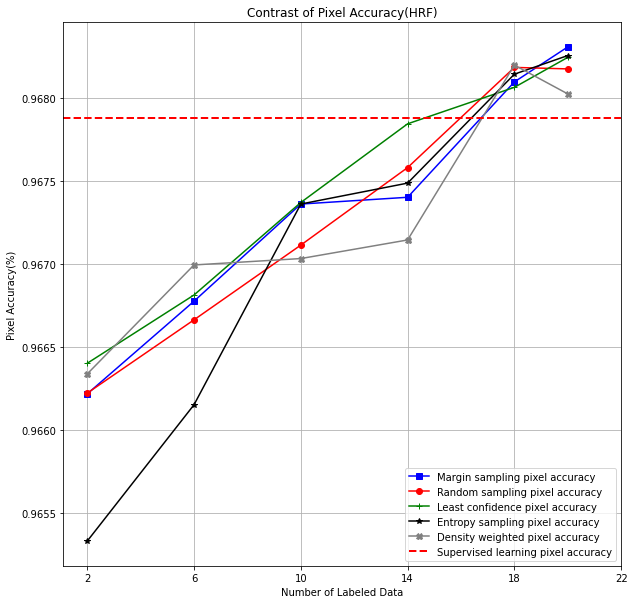

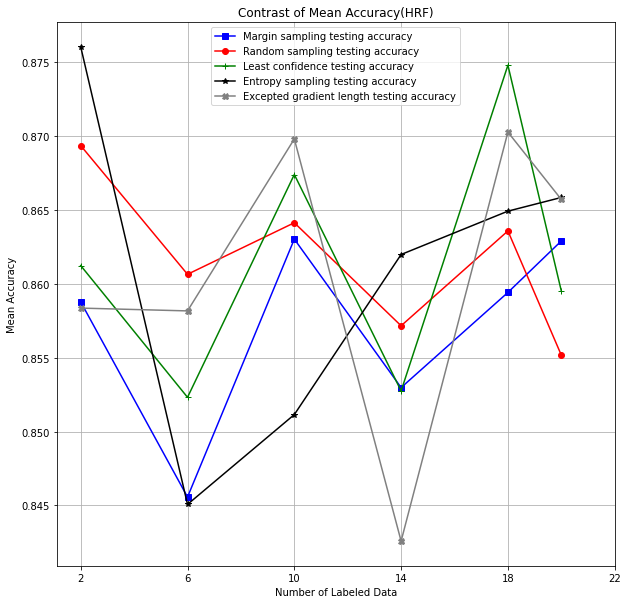

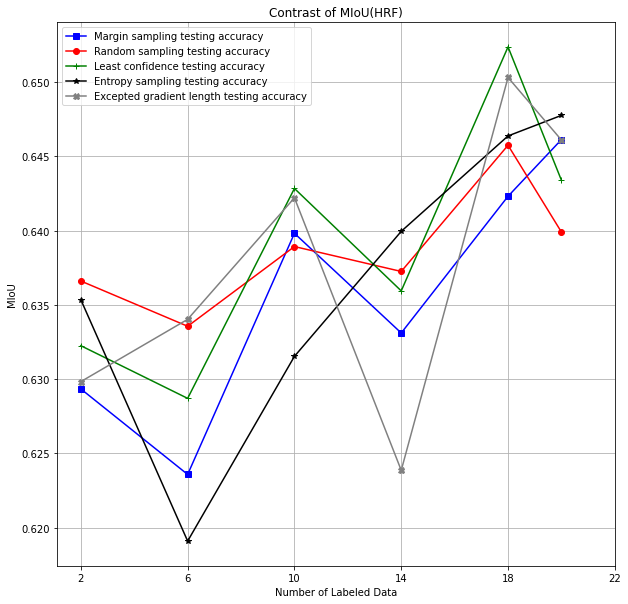

Specificity Output:
margin_sampling{'margin_sampling_specificity': [0.9862073952892356, 0.9893249754654801, 0.9867697200682611, 0.9886874328790278, 0.9883120946548534, 0.9879132764617543, 0.990453583855501]}
random_sampling{'random_sampling_specificity': [0.9842443948058487, 0.9863873856324159, 0.9862709072400621, 0.9881208421172761, 0.987640970252381, 0.9891939244761339]}
least_confidence{'least_confidence_specificity': [0.9859680224665079, 0.9881135387548491, 0.9859676129321663, 0.989253375211405, 0.9854119772140553, 0.9884685026455236]}
entropy_sampling{'entropy_sampling_specificity': [0.9819469754045961, 0.9886794469593645, 0.988979226097494, 0.9871127392073026, 0.9873435118088545, 0.9873039917448798]}
density_weighted{'density_weighted_specificity': [0.9864272128471469, 0.9872394900860609, 0.985119842716971, 0.9903160485724111, 0.9864124354829836, 0.9870550972487073]}


Sensitivity Output:
margin_sampling{'margin_sampling_sensitivity': [0.7313396384705337, 0.7018095722377194, 0.73

In [ ]:
#make pixel accuracy comparsion between different methods
import matplotlib.pyplot as plt
import pickle

annotated_num = [2, 6, 10, 14, 18, 20]  #, 20

dataset = 'HRF'

#Pixel Accuracy
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/margin_sampling_accuracy.txt','rb+') as file_pi:
  margin_test_accuracy = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/random_sampling_accuracy.txt','rb+') as file_pi:
  random_test_accuracy = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/least_confidence_accuracy.txt','rb+') as file_pi:
  least_test_accuracy = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/entropy_sampling_accuracy.txt','rb+') as file_pi:
  entropy_test_accuracy = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/density_weighted_accuracy.txt','rb+') as file_pi:
  density_weighted_accuracy = pickle.load(file_pi)

plt.figure(figsize=(10,10))
plt.plot(annotated_num, margin_test_accuracy['margin_sampling_accuracy'][0:len(annotated_num)],'blue',label='Margin sampling pixel accuracy',Marker='s')
plt.plot(annotated_num, random_test_accuracy['random_sampling_accuracy'],'red',label='Random sampling pixel accuracy',Marker='o')
plt.plot(annotated_num, least_test_accuracy['least_confidence_accuracy'],'green',label='Least confidence pixel accuracy',Marker='+')
plt.plot(annotated_num, entropy_test_accuracy['entropy_sampling_accuracy'],'black',label='Entropy sampling pixel accuracy',Marker='*')
plt.plot(annotated_num, density_weighted_accuracy['density_weighted_accuracy'],'gray',label='Density weighted pixel accuracy',Marker='X')
plt.axhline(y=margin_test_accuracy['margin_sampling_accuracy'][len(annotated_num)],c="r",ls="--",lw=2, label='Supervised learning pixel accuracy')
plt.title('Contrast of Pixel Accuracy(HRF)')
plt.xlabel('Number of Labeled Data')
plt.ylabel('Pixel Accuracy(%)')
plt.xticks(range(2,24,4))
plt.grid(b=True,axis='x')
plt.grid(b=True,axis='y')
plt.legend()
plt.show()

#Mean Accuracy
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/margin_sampling_mean_accuracy.txt','rb+') as file_pi:
  margin_mean_accuracy = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/random_sampling_mean_accuracy.txt','rb+') as file_pi:
  random_mean_accuracy = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/least_confidence_mean_accuracy.txt','rb+') as file_pi:
  least_mean_accuracy = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/entropy_sampling_mean_accuracy.txt','rb+') as file_pi:
  entropy_mean_accuracy = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/density_weighted_mean_accuracy.txt','rb+') as file_pi:
  density_mean_accuracy = pickle.load(file_pi)

plt.figure(figsize=(10,10))
plt.plot(annotated_num, margin_mean_accuracy['margin_sampling_mean_accuracy'][0:len(annotated_num)],'blue',label='Margin sampling testing accuracy',Marker='s')
plt.plot(annotated_num, random_mean_accuracy['random_sampling_mean_accuracy'],'red',label='Random sampling testing accuracy',Marker='o')
plt.plot(annotated_num, least_mean_accuracy['least_confidence_mean_accuracy'],'green',label='Least confidence testing accuracy',Marker='+')
plt.plot(annotated_num, entropy_mean_accuracy['entropy_sampling_mean_accuracy'],'black',label='Entropy sampling testing accuracy',Marker='*')
plt.plot(annotated_num, density_mean_accuracy['density_weighted_mean_accuracy'],'gray',label='Excepted gradient length testing accuracy',Marker='X')
plt.title('Contrast of Mean Accuracy(HRF)')
plt.xlabel('Number of Labeled Data')
plt.ylabel('Mean Accuracy')
plt.xticks(range(2,24,4))
plt.grid(b=True,axis='x')
plt.grid(b=True,axis='y')
plt.legend()
plt.show()

#Mean IoU
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/margin_sampling_mean_iou.txt','rb+') as file_pi:
  margin_mean_iou = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/random_sampling_mean_iou.txt','rb+') as file_pi:
  random_mean_iou = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/least_confidence_mean_iou.txt','rb+') as file_pi:
  least_mean_iou = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/entropy_sampling_mean_iou.txt','rb+') as file_pi:
  entropy_mean_iou = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/density_weighted_mean_iou.txt','rb+') as file_pi:
  density_mean_iou = pickle.load(file_pi)

plt.figure(figsize=(10,10))
plt.plot(annotated_num, margin_mean_iou['margin_sampling_mean_iou'][0:len(annotated_num)],'blue',label='Margin sampling testing accuracy',Marker='s')
plt.plot(annotated_num, random_mean_iou['random_sampling_mean_iou'],'red',label='Random sampling testing accuracy',Marker='o')
plt.plot(annotated_num, least_mean_iou['least_confidence_mean_iou'],'green',label='Least confidence testing accuracy',Marker='+')
plt.plot(annotated_num, entropy_mean_iou['entropy_sampling_mean_iou'],'black',label='Entropy sampling testing accuracy',Marker='*')
plt.plot(annotated_num, density_mean_iou['density_weighted_mean_iou'],'gray',label='Excepted gradient length testing accuracy',Marker='X')
plt.title('Contrast of MIoU(HRF)')
plt.xlabel('Number of Labeled Data')
plt.ylabel('MIoU')
plt.xticks(range(2,24,4))
plt.grid(b=True,axis='x')
plt.grid(b=True,axis='y')
plt.legend()
plt.show()

#specificity
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/margin_sampling_specificity.txt','rb+') as file_pi:
  margin_specificity = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/random_sampling_specificity.txt','rb+') as file_pi:
  random_specificity = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/least_confidence_specificity.txt','rb+') as file_pi:
  least_specificity = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/entropy_sampling_specificity.txt','rb+') as file_pi:
  entropy_specificity = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/density_weighted_specificity.txt','rb+') as file_pi:
  density_specificity = pickle.load(file_pi)

print('Specificity Output:')
print('margin_sampling'+str(margin_specificity))
print('random_sampling'+str(random_specificity))
print('least_confidence'+str(least_specificity))
print('entropy_sampling'+str(entropy_specificity))
print('density_weighted'+str(density_specificity))

#sensitivity
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/margin_sampling_sensitivity.txt','rb+') as file_pi:
  margin_sensitivity = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/random_sampling_sensitivity.txt','rb+') as file_pi:
  random_sensitivity = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/least_confidence_sensitivity.txt','rb+') as file_pi:
  least_sensitivity = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/entropy_sampling_sensitivity.txt','rb+') as file_pi:
  entropy_sensitivity = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/density_weighted_sensitivity.txt','rb+') as file_pi:
  density_sensitivity = pickle.load(file_pi)

print('\n')
print('Sensitivity Output:')
print('margin_sampling'+str(margin_sensitivity))
print('random_sampling'+str(random_sensitivity))
print('least_confidence'+str(least_sensitivity))
print('entropy_sampling'+str(entropy_sensitivity))
print('density_weighted'+str(density_sensitivity))

#F1-score
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/margin_sampling_f1score.txt','rb+') as file_pi:
  margin_f1score = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/random_sampling_f1score.txt','rb+') as file_pi:
  random_f1score = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/least_confidence_f1score.txt','rb+') as file_pi:
  least_f1score = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/entropy_sampling_f1score.txt','rb+') as file_pi:
  entropy_f1score = pickle.load(file_pi)
with open('/content/drive/MyDrive/MyProject/'+dataset+'/testing_records/density_weighted_f1score.txt','rb+') as file_pi:
  density_f1score = pickle.load(file_pi)

print('\n')
print('F1 score Output:')
print('margin_sampling'+str(margin_f1score))
print('random_sampling'+str(random_f1score))
print('least_confidence'+str(least_f1score))
print('entropy_sampling'+str(entropy_f1score))
print('density_weighted'+str(density_f1score))


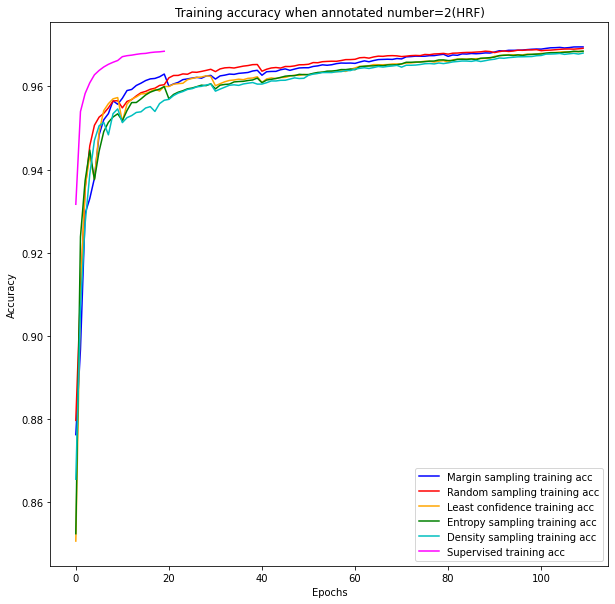

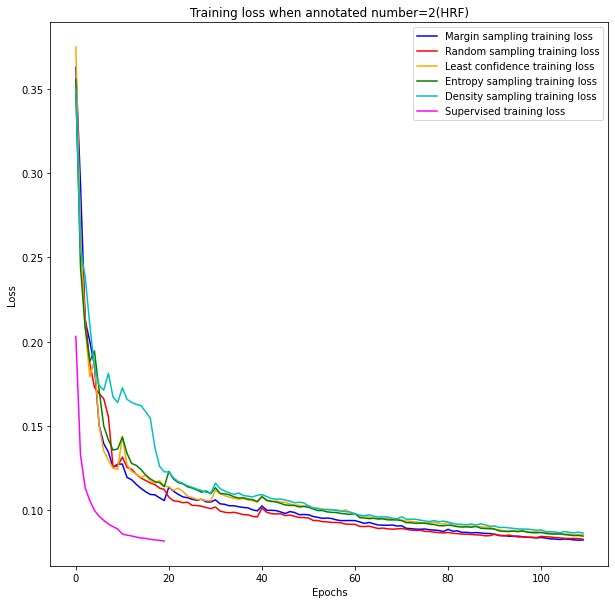

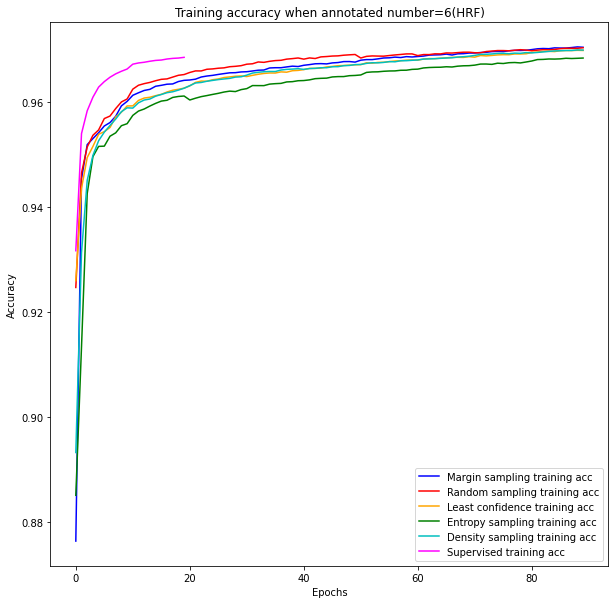

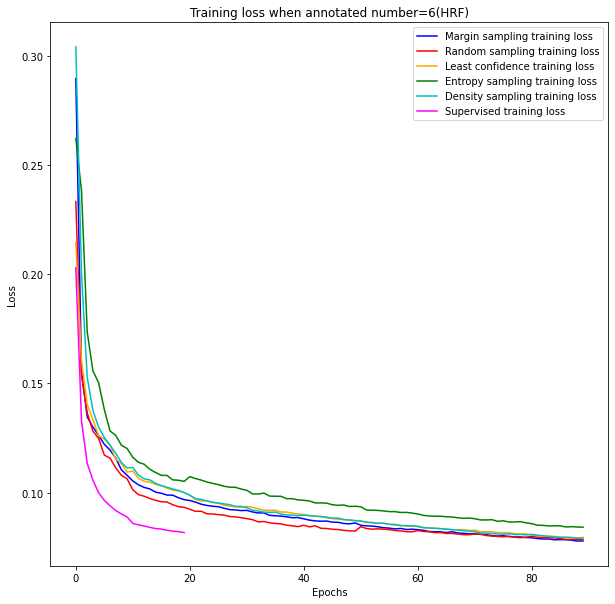

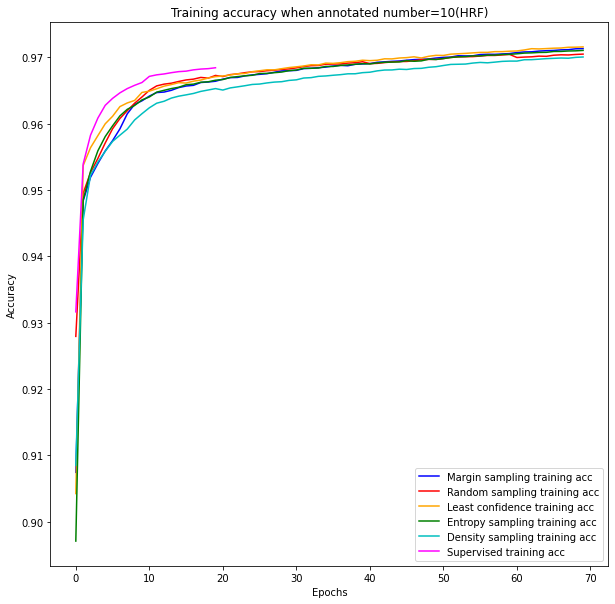

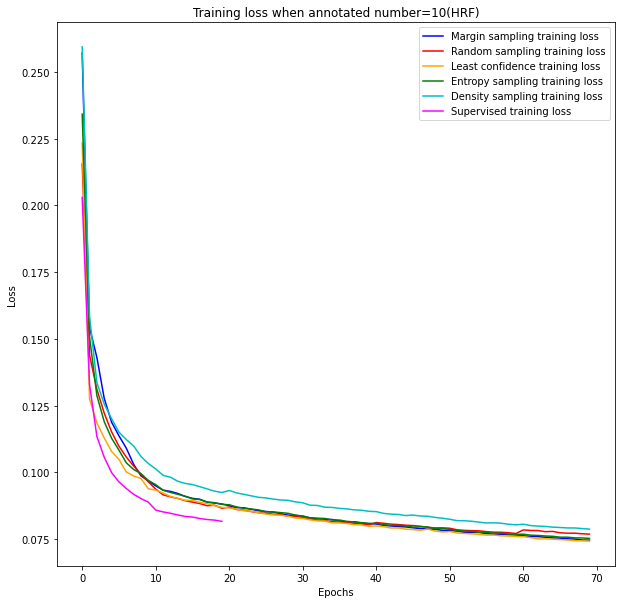

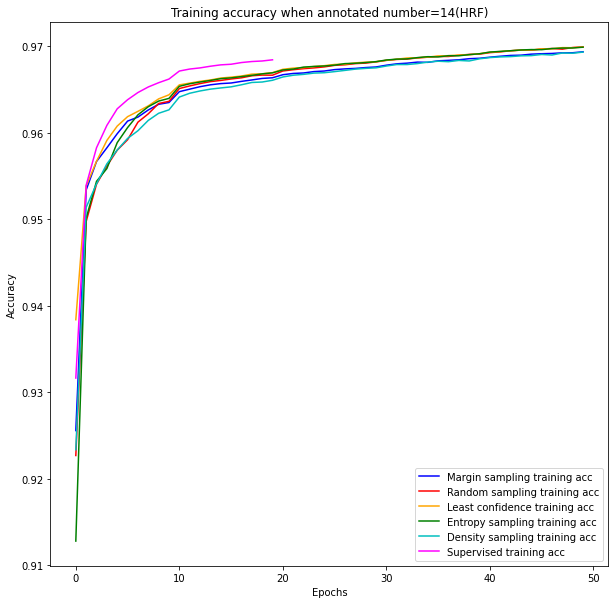

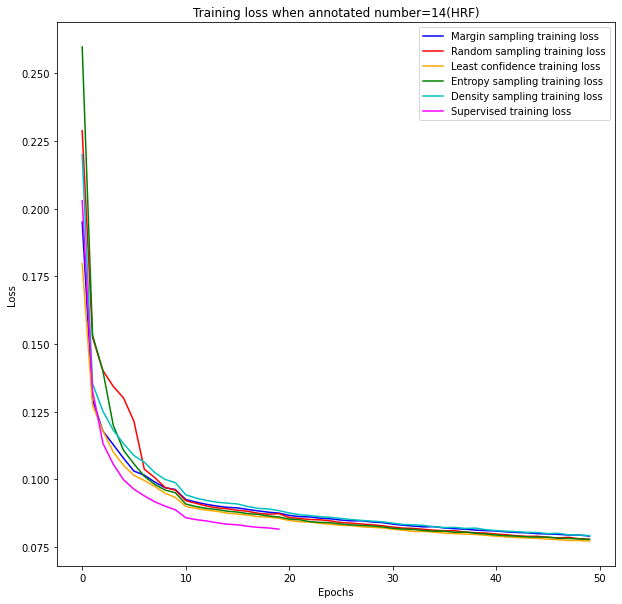

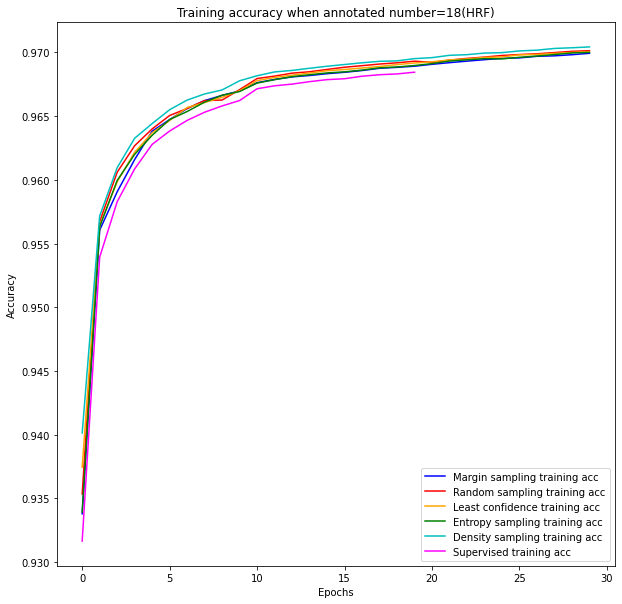

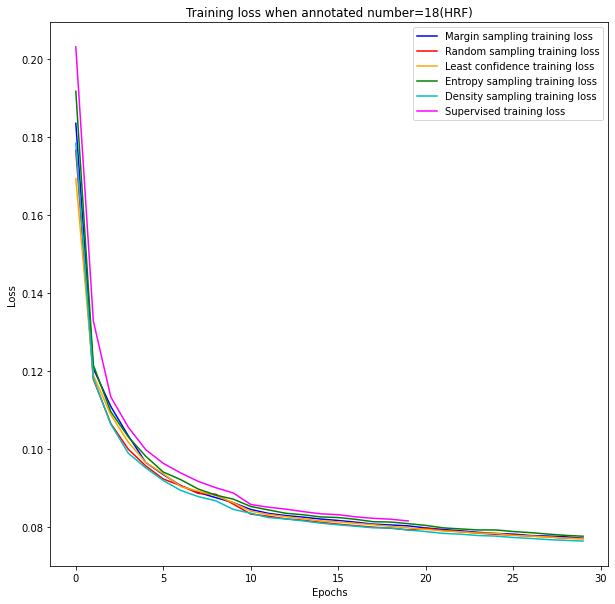

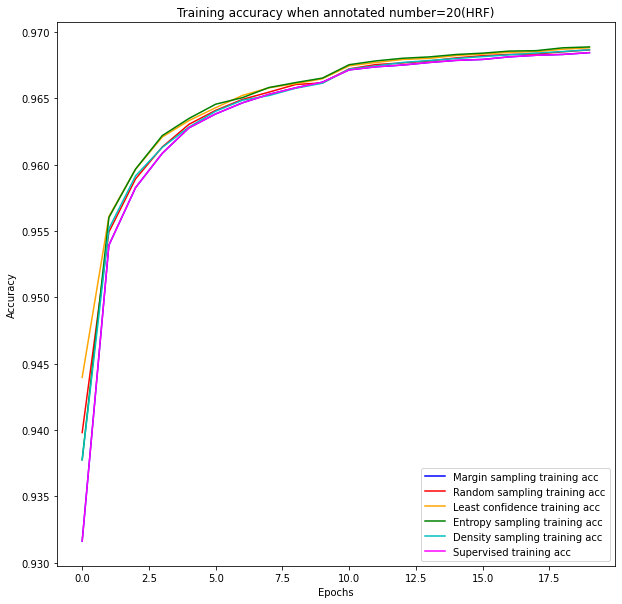

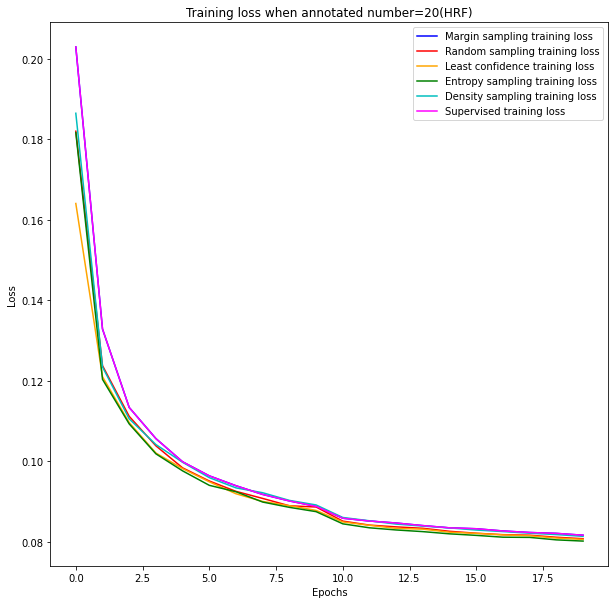

In [ ]:
import matplotlib.pyplot as plt
import pickle

annotated_num = [2, 6, 10, 14, 18, 20]  #, 20

dataset = 'HRF'

for i in annotated_num:
  #get related info of active learning training history
  with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/margin_sampling_'+str(i)+'.txt','rb+') as file_pi:
    margin_history = pickle.load(file_pi)
  with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/random_sampling_'+str(i)+'.txt','rb+') as file_pi:
    random_history = pickle.load(file_pi)
  with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/least_confidence_'+str(i)+'.txt','rb+') as file_pi:
    least_history = pickle.load(file_pi)
  with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/entropy_sampling_'+str(i)+'.txt','rb+') as file_pi:
    entropy_history = pickle.load(file_pi)
  with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/density_weighted_'+str(i)+'.txt','rb+') as file_pi:
    density_history = pickle.load(file_pi)
  margin_accuracy = margin_history['accuracy'] 
  margin_loss =  margin_history['loss']
  random_accuracy = random_history['accuracy'] 
  random_loss =  random_history['loss']
  least_accuracy = least_history['accuracy'] 
  least_loss =  least_history['loss']
  entropy_accuracy = entropy_history['accuracy'] 
  entropy_loss =  entropy_history['loss']
  density_accuracy = density_history['accuracy'] 
  density_loss =  density_history['loss']

  margin_epochs = range(0, len(margin_accuracy))
  random_epochs = range(0, len(random_accuracy))
  least_epochs = range(0, len(least_accuracy))
  entropy_epochs = range(0, len(entropy_accuracy))
  density_epochs = range(0, len(density_accuracy))

  #get related info of supervised learning history
  with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/margin_sampling_'+str(20)+'.txt','rb+') as file_pi:
    supervised_margin = pickle.load(file_pi)
  with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/random_sampling_'+str(20)+'.txt','rb+') as file_pi:
    supervised_random = pickle.load(file_pi)
  supervised_margin_accuracy = supervised_margin['accuracy']
  supervised_random_accuracy = supervised_random['accuracy']
  supervised_margin_loss = supervised_margin['loss']
  supervised_random_loss = supervised_random['loss']
  supervised_margin_epochs = range(0, len(supervised_margin_accuracy))
  supervised_random_epochs = range(0, len(supervised_random_accuracy))
  

  plt.figure(figsize=(10,10))
  plt.plot(margin_epochs,margin_accuracy,'b',label='Margin sampling training acc')
  plt.plot(random_epochs,random_accuracy,'r',label='Random sampling training acc')
  plt.plot(least_epochs,least_accuracy,'orange',label='Least confidence training acc')
  plt.plot(entropy_epochs,entropy_accuracy,'g',label='Entropy sampling training acc')
  plt.plot(density_epochs,density_accuracy,'c',label='Density sampling training acc')
  plt.plot(supervised_margin_epochs,supervised_margin_accuracy,'fuchsia',label='Supervised training acc')
  plt.title('Training accuracy when annotated number='+str(i)+'(HRF)')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.figure(figsize=(10,10))
  plt.plot(margin_epochs,margin_loss,'b',label='Margin sampling training loss')
  plt.plot(random_epochs,random_loss,'r',label='Random sampling training loss')
  plt.plot(least_epochs,least_loss,'orange',label='Least confidence training loss')
  plt.plot(entropy_epochs,entropy_loss,'g',label='Entropy sampling training loss')
  plt.plot(density_epochs,density_loss,'c',label='Density sampling training loss')
  plt.plot(supervised_margin_epochs,supervised_margin_loss,'fuchsia',label='Supervised training loss')
  plt.title('Training loss when annotated number='+str(i)+'(HRF)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()